In [112]:
import time
import matplotlib.pyplot as plt
import torch
import numpy as np
from laplacian_py import laplacian_solver
print(laplacian_solver.__dir__())

res = 300
max_val = res//4

values = max_val*torch.ones((res, res),dtype=torch.float32, device='cuda')
boundary_conditions = torch.zeros((res,res),dtype=torch.float32, device='cuda')
boundary_types = torch.zeros((res,res),dtype=torch.float32, device='cuda')


obj1_ind1 = int(res*18/30)
obj1_ind2 = int(res*2/3)
obj1_ind3 = int(res*0)
obj1_ind4 = int(res*2/3)
boundary_conditions[obj1_ind1:obj1_ind2, obj1_ind3:obj1_ind4] = max_val
boundary_types[obj1_ind1:obj1_ind2, obj1_ind3:obj1_ind4] = 1.0

obj2_ind1 = int(res*3/12)
obj2_ind2 = int(res*4/12)
obj2_ind3 = int(res*1/3)
obj2_ind4 = int(res*28/30)
boundary_conditions[obj2_ind1:obj2_ind2, obj2_ind3:obj2_ind4] = max_val
boundary_types[obj2_ind1:obj2_ind2, obj2_ind3:obj2_ind4] = 1.0

# boundary_conditions[2*60:2*80, 2*60:2*80] = 0
# boundary_types[2*60:2*80, 2*60:2*80] = 1.0

ind1 = int(res*2/30)
ind2 = int(res*2/30)
boundary_conditions[ind1, ind2] = 0.0
boundary_types[ind1, ind2] = 1.0

ind1 = int(res*6/30)
ind2 = int(res*22/30)
boundary_conditions[ind1, ind2] = 0.0
boundary_types[ind1, ind2] = 1.0

# inds = np.random.rand(boundary_conditions.shape[0], boundary_conditions.shape[1]) > .999
# boundary_conditions[inds] = 100
# boundary_types[inds] = 1.0

def get_edge_inds(grid_size, dim_index):
    offset = 1
    XYZ = [np.linspace(0, s-1, s, dtype=np.int32) for s in grid_size]
    out = np.meshgrid(*XYZ)
    tmp = np.vstack([val.flatten() for val in out])
    inds1 = tmp[dim_index, :] == 0 + offset
    inds2 = tmp[dim_index, :] == grid_size[dim_index] -1 -offset
    inds = np.any(np.vstack([inds1, inds2]), axis=0)
    return np.reshape(inds, grid_size) 

# edge_inds_x = get_edge_inds(values.shape, 0)
# boundary_conditions[edge_inds_x] = 40
# boundary_types[edge_inds_x] = 1 # flux x

# edge_inds_y = get_edge_inds(values.shape, 1)
# boundary_conditions[edge_inds_y] = 40
# boundary_types[edge_inds_y] = 1 # flux y

XYZ = [np.linspace(0, 1, res, dtype=np.float32) for _ in range(2)]
X, Y = np.meshgrid(*XYZ)
# cost = .005*torch.tensor(10*(1-X)*(1-Y),dtype=torch.float32, device='cuda')
cost = .005*torch.ones(res,res,dtype=torch.float32, device='cuda')
safe = res//15
cost[max(obj1_ind1-safe, 0):min(obj1_ind2+safe, res-1), max(obj1_ind3-safe, 0):min(obj1_ind4+safe, res-1)] = .1
cost[max(obj2_ind1-safe, 0):min(obj2_ind2+safe, res-1), max(obj2_ind3-safe, 0):min(obj2_ind4+safe, res-1)] = .1

x = torch.stack([values, boundary_types, boundary_conditions, cost], axis=2)



# start = time.time()
# x = np.zeros((100,100),dtype=np.float32)
# for i in range(100000):
#     x = x + 1
# end = time.time()
# print(end - start)




['__name__', '__doc__', '__package__', '__loader__', '__spec__', 'solve', '__file__']


In [113]:
start = time.time()
for i in range(100000):
    laplacian_solver.solve(x)
end = time.time()
print(end - start)

0.2656209468841553


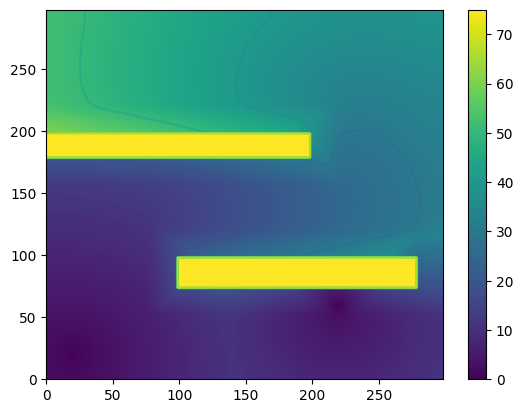

In [114]:

z = x.cpu().numpy()[1:-1, 1:-1, 0]
# z = x.cpu().numpy()[:, :, 1]
# z = boundary_types.cpu()
# z = edge_inds_y*100
# z = x.cpu().numpy()[:, :, 0]
# z = boundary.cpu().numpy()
plt.pcolormesh(z)
# plt.pcolormesh(np.log(z+1))
plt.colorbar()
plt.contour(z)
plt.show()

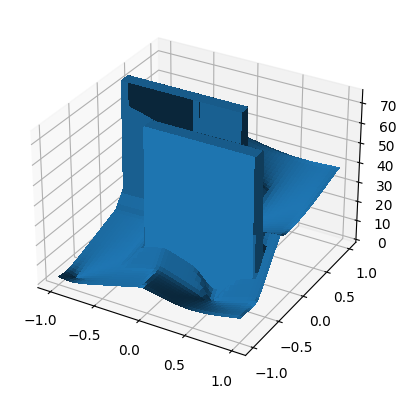

In [115]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X = np.linspace(-1, 1, z.shape[0])
Y = np.linspace(-1, 1, z.shape[1])
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(X,Y,z,linewidth=0, antialiased=False)

In [103]:
# import sys
# np.set_printoptions(threshold=sys.maxsize)
# print(edge_inds_x)
# print(edge_inds_x[:,1])
# print(edge_inds_y[-2, :])
# print(z)
# print(np.sum(z ==40.1))

In [6]:
inds = np.random.rand(boundary_conditions.shape[0], boundary_conditions.shape[1]) > .4
boundary_conditions[inds > .4] = 0.0
boundary_types[inds] = 1.0
inds

array([[False, False,  True, ...,  True,  True, False],
       [False,  True,  True, ...,  True, False,  True],
       [ True, False, False, ...,  True, False,  True],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True, False, ...,  True,  True,  True]])

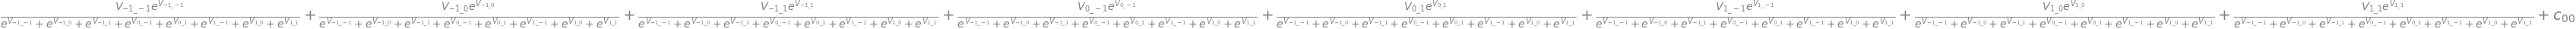

In [155]:
import sympy
from sympy import *

Vs = [symbols('V_{'+f'{i}\_{j}' +'}') for i in [-1,0,1] for j in [-1,0,1] if i!=0 or j!=0]
V = symbols(f'V00')
c = symbols(f'c00')
init_printing(use_unicode=True, wrap_line=False)

expression = c + sum([vi*exp(vi)/(sum([exp(vj) for vj in Vs])) for vi in Vs])
expression

d/dV_{-1\_-1}


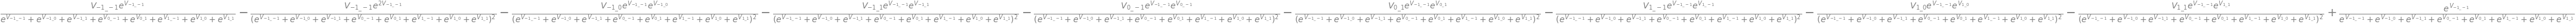

In [174]:
print(f'd/d{Vs[0].name}')
derivative = diff(expression, Vs[0])
derivative

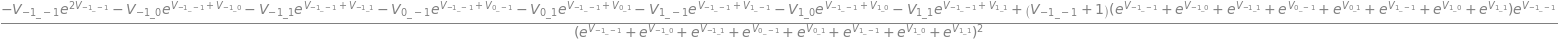

In [178]:
factor = 1/(sum([exp(vj) for vj in Vs]))
# derivative = sympy.collect(derivative, factor)
derivative = derivative.simplify()

derivative

In [157]:
print('d/dc')
diff(expression, c)

d/dc


'V_{-1-1}'